In [15]:
import math
import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # ポップアウトウィンドウを表示しないようにする
from ple import PLE
from ple.games.flappybird import FlappyBird
from collections import defaultdict
from itertools import chain

In [16]:
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps
    import moviepy.editor as mpy

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip, duration

In [17]:
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display

def display_frames_as_gif(frames):
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])
    
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
    
    anim.save('movie_flappy_bird_DQN.mp4')
    display(display_animation(anim, default_mode='loop'))

In [18]:
def make_graph(reward_per_epoch, lifetime_per_epoch):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(10,4))
    axL.set_title('lifetime')
    axL.grid(True)
    axL.plot(lifetime_per_epoch)
    axR.set_title('reward')
    axR.grid(True)
    axR.plot(reward_per_epoch)
    fig.show()

In [19]:
from collections import namedtuple

Transition = namedtuple('Transicion', ('state', 'action', 'next_state', 'reward'))

In [20]:
GAMMA = 0.99 # 時間割引率
MAX_STEPS = 1200 # 1試行のstep数(フレーム数)
NUM_EPISODES = 800 # 最大試行回数
PRINT_EVERY_EPISODE = 50
SHOW_GIF_EVERY_EPISODE = 100

In [21]:
class ReplayMemory:
    
    def __init__(self, CAPACITY):
        self.capacity = CAPACITY #メモリの最大値
        self.memory = [] # 経験を保存するリスト
        self.index = 0 # 保存するindexを表す変数
    
    def push(self, state, action, state_next, reward):
        '''trasicion = (state, action, state_next, reward)をメモリ保存する'''
        
        if len(self.memory) < self.capacity:
            self.memory.append(None) # メモリが満タンじゃないときは足す
            
        # namedtupleのTransitionを用意し、値とフィールド名をペアにする
        self.memory[self.index] = Transition(state, action, state_next, reward)
            
        self.index = (self.index + 1) % self.capacity # 保存するindexを1つずらす
        
    def sample(self, batch_size):
        '''batch_sizeだけ、ランダムに取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在のmemoryの長さを返す'''
        return len(self.memory)

In [22]:
import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [23]:
BATCH_SIZE = 32
CAPACITY = 10000

In [24]:
class Net(nn.Module):
    
    def __init__(self, num_states, num_actions):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_states, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, num_actions)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [25]:
class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions # 行動の数を取得
        
        # 経験を保存するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)
        
        # NNを構築
        self.model = Net(num_states, num_actions)
        
        print(self.model) # ネットワークの形を出力
        
        # target_net
        self.target_net = copy.deepcopy(self.model)
        self.target_net.load_state_dict(self.model.state_dict())
        
        # 最適化手法の設定
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        #self.optimizer = optim.Adam(self.target_net.parameters(), lr=0.001)
        
    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを出力'''
        
        # ------------------------------------------------------------
        # 1.メモリサイズの確認
        # ------------------------------------------------------------
        # 1.1 メモリサイズがミニバッチより小さい間は何もしない
        if len(self.memory) < BATCH_SIZE:
            return
        
        # ------------------------------------------------------------
        # 2. ミニバッチの作成
        # ------------------------------------------------------------
        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)
        
        # 2.2 各変数をミニバッチに対応する形に変形
        # trainsicionsは1stepごとの(state, action. state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)xBATCH_SIZE
        # これをミニバッチにしたい
        # (state x BATCH_SIZE, action x BATCH_SIZE, state_next x BATCH_SIZE, reward x BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))
        
        # 2.3  各変数の要素をミニバッチに対応する形に変形する
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるが、
        # それを torch.FloatTensor of BATCH_SIZE x 4に変換する
        # cat は Concatenates(結合)のこと
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        # ------------------------------------------------------------
        # 3. 教師信号となるQ(s_t, a_t)値を求める
        # ------------------------------------------------------------
        # 3.1 ネットワークを推論モードに切り替える
        self.model.eval()
        
        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZE x 2]になっている
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが
        # 右か左かのindexを求め、それに対応するQ値をgatherで引っ張り出す
        state_action_values = self.model(state_batch).gather(1, action_batch)
        
        # 3.3 max{Q(s_t+1, a)}値を求める。ただし、次の状態があるかに注意。
        
        # flappybirdがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(
            tuple(map(lambda s: s is not None, batch.next_state)))
        
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)
        
        # 次の状態があるindexの最大Q値を求める
        # 出力にアクセスし、max(1)で列方向の最大値の[値、index]を求める
        # そしてそのQ値を取り出します
        self.target_net.eval()
        next_state_values[non_final_mask] = self.target_net(
            non_final_next_states).max(1)[0].detach()
        
        # 3.4 教師となるQ値を、Q学習の式から求める
        #expected_state_action_values = reward_batch + GAMMA * next_state_values
        #print(expected_state_action_values.unsqueeze(1))
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        #print(expected_state_action_values)
        
        # ------------------------------------------------------------
        # 4. 結合パラメータの更新　
        # ------------------------------------------------------------
        # 4.1 ネットワークを訓練モードに切り替える
        self.model.train()
        #self.target_net.train()
        
        # 4.2 損失関数を計算する (smooth_l1_lossはHuberloss)
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているから、unsqueezeで[minbatch x 1]へ
        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
        #print(state_action_values.size())
        #print(expected_state_action_values.size())
        
        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad() # 勾配をリセット
        loss.backward() # バックプロパゲーションを計算
        self.optimizer.step() # 結合パラメータを更新
    
    def update_target_model(self):
        #self.model = copy.deepcopy(self.target_net)
        #self.target_net = copy.deepcopy(self.model)
        self.target_net.load_state_dict(self.model.state_dict())
    
    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.41 * (1 / (episode + 1))
        
        if epsilon <= np.random.uniform(0, 1):
            self.model.eval() # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.model(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出す = max(1)[1]
            # .view(1, 1)は[torch.LongTensor of size 1] を size 1x1 に変換する
        
        else:
            # 0, 1の行動をランダムに返す
            action = torch.LongTensor(
                    [[random.randrange(self.num_actions)]])
            # actionは[torch.LongTensor of size 1x1]の形になる
        
        return action
    
    def brain_predict(self, state):
        self.model.eval() # ネットワークを推論モードに切り替える
        with torch.no_grad():
            action = self.model(state).max(1)[1].view(1, 1)
        return action

In [26]:
class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)
        # エージェントが行動を決定するための頭脳を生成
        
    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()
        
    def update_target_model(self):
        self.brain.update_target_model()
        
    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action
    
    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)
    
    def predict_action(self, state):
        action = self.brain.brain_predict(state)
        return action

In [27]:
class Environment:
    
    def __init__(self):
        self.game = FlappyBird()
        self.env = PLE(self.game, fps=30, display_screen=False)
        self.num_states = len(self.game.getGameState())  # 8
        self.num_actions = len(self.env.getActionSet()) # 1
        self.agent = Agent(self.num_states, self.num_actions)
    
    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10) # 10試行分の成功したstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0 # 195step以上連続で立ち続けた試行数
        episode_final = False # 最後の試行フラグ
        reward_per_epoch = []
        lifetime_per_epoch = []
        #frames = [] #最後の試行を動画にするための変数
        
        for episode in range(NUM_EPISODES): # 試行回数分繰り返す
            
            self.env.reset_game() # 環境の初期化
            observation = self.game.getGameState() # 観測をそのまま状態sとして使用
            state = observation
            state = np.array(list(self.get_relative_state(state)))
            #state = np.array(list(state.values()))
            state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
            # FloatTensor size 4 を size 1x4に変換
            state = torch.unsqueeze(state, 0)
            
            # record frame
            frames = [self.env.getScreenRGB()]
            
            cum_reward = 0  # このエピソードにおける累積報酬の和
            t = 0
            
            step = 0
            
            if episode % 50 == 0:
                self.agent.update_target_model()
            
            #for step in range(MAX_STEPS):
            while not self.env.game_over():
                step += 1
                #step+=1
                #if episode_final is True: 
                #    frames.append(self.env.getScreenRGB())
                
                action = self.agent.get_action(state, episode) # 行動を求める
                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                #print(self.env.act(action.item()))
                rew = self.env.act(self.env.getActionSet()[action])
                t += 1
                #observation_next, _, done, _ = self.env.step(action.item()) # rewardとinfoは使わないから _ にする
                observation_next = self.game.getGameState() 
                done = self.game.game_over()
                
                frames.append(self.env.getScreenRGB())
                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))
                    
                    # 罰則を与える
                    reward = torch.FloatTensor([-1.0])
                    
                    #if step < GOAL_FRAME:
                    #    reward = torch.FloatTensor(
                    #        [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                    #    complete_episodes = 0  # 連続成功記録をリセット
                    #else:
                    #    reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                    #    complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    if rew > 0:
                        reward = torch.FloatTensor([1.0])
                    else:
                        reward = torch.FloatTensor([0.1])  # 普段は報酬0
                    #reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = np.array(list(self.get_relative_state(state_next)))
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                cum_reward += rew
                
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()
                #if episode % 5 == 0:
                #    self.agent.update_target_q_function()
                #else:
                #    self.agent.update_q_function()

                # 観測の更新
                state = state_next
                
                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    reward_per_epoch.append(cum_reward)
                    lifetime_per_epoch.append(step+1)
                    break
                    
            if episode_final is True:
                # 動画の保存と描画
                display_frames_as_gif(frames)
                break
            # 10連続で200step成功し続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True
                    
        
            # 50エピソード毎にlogを出力
            if episode % PRINT_EVERY_EPISODE == 0:
                print("Episode %d finished after %f time steps" % (episode, t))
                print("cumulated reward: %f" % cum_reward)
                #reward_per_epoch.append(cum_reward)
                #lifetime_per_epoch.append(t)
                #if len(frames) > GOAL_FRAME:
                #    print("len frames:", len(frames))
                #    clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
                #    display(clip.ipython_display(fps=60, autoplay=1, loop=1))
                #    break
                #    #if self.graph == True:
                #    #    make_graph(reward_per_epoch, lifetime_per_epoch)
                

            # 100エピソード毎にアニメーションを作成
            if episode % SHOW_GIF_EVERY_EPISODE == 0:
                print("len frames:", len(frames))
                clip, duration = make_anim(frames, fps=60, true_image=True)
                clip = clip.rotate(-90)
                display(clip.ipython_display(fps=60, autoplay=1, loop=1, max_duration = duration))
                
        # グラフの作成
        make_graph(reward_per_epoch, lifetime_per_epoch)
    
    bucket_range_per_feature = {
        'next_next_pipe_bottom_y': 40,
        'next_next_pipe_dist_to_player': 512,
        'next_next_pipe_top_y': 40,
        'next_pipe_bottom_y': 20,
        'next_pipe_dist_to_player': 20,
        'next_pipe_top_y': 20,
        'player_vel': 4,
        'player_y': 16
    }
    
    def get_relative_state(self, state):
        # パイプの絶対位置の代わりに相対位置を使用する
        state = copy.deepcopy(state)
        state['next_next_pipe_bottom_y'] -= state['player_y']
        state['next_next_pipe_top_y'] -= state['player_y']
        state['next_pipe_bottom_y'] -= state['player_y']
        state['next_pipe_top_y'] -= state['player_y']

        # アルファベット順に並び替える
        state_key = [k for k, v in sorted(state.items())]

        # 相対位置を返す
        state_idx = []
        for key in state_key:
            state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
        return tuple(state_idx)
    
    def play(self):
        self.env.reset_game() # 環境の初期化
        observation = self.game.getGameState() # 観測をそのまま状態sとして使用
        state = observation
        state = np.array(list(self.get_relative_state(state)))
        state = torch.from_numpy(state).type(torch.FloatTensor) # numpy変数をPyTorchのテンソルに変換
        # FloatTensor size 4 を size 1x4に変換
        state = torch.unsqueeze(state, 0)
        # record frame
        frames = [self.env.getScreenRGB()]
        
        while not self.env.game_over():
            action = self.agent.predict_action(state)
            # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
            # actionから.item()を指定して、中身を取り出す
            #print(self.env.act(action.item()))
            rew = self.env.act(self.env.getActionSet()[action])
            observation_next = self.game.getGameState() 
            done = self.game.game_over()
            frames.append(self.env.getScreenRGB())
        
        print("len frames:", len(frames))
        clip, duration = make_anim(frames, fps=60, true_image=True)
        clip = clip.rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, max_duration = duration))
    
    def save_model():
        torch.save(agent.brain.model.state_dict(), 'weight.pth')
        

Net(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)


  3%|▎         | 2/64 [00:00<00:03, 19.43it/s]

0 Episode: Finished after 63 steps：10試行の平均step数 = 6.3
Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 163.55it/s]


1 Episode: Finished after 64 steps：10試行の平均step数 = 12.7
2 Episode: Finished after 56 steps：10試行の平均step数 = 18.3
3 Episode: Finished after 63 steps：10試行の平均step数 = 24.6
4 Episode: Finished after 63 steps：10試行の平均step数 = 30.9
5 Episode: Finished after 63 steps：10試行の平均step数 = 37.2
6 Episode: Finished after 57 steps：10試行の平均step数 = 42.9
7 Episode: Finished after 46 steps：10試行の平均step数 = 47.5
8 Episode: Finished after 63 steps：10試行の平均step数 = 53.8
9 Episode: Finished after 63 steps：10試行の平均step数 = 60.1
10 Episode: Finished after 63 steps：10試行の平均step数 = 60.1
11 Episode: Finished after 63 steps：10試行の平均step数 = 60.0
12 Episode: Finished after 55 steps：10試行の平均step数 = 59.9
13 Episode: Finished after 63 steps：10試行の平均step数 = 59.9
14 Episode: Finished after 63 steps：10試行の平均step数 = 59.9
15 Episode: Finished after 63 steps：10試行の平均step数 = 59.9
16 Episode: Finished after 62 steps：10試行の平均step数 = 60.4
17 Episode: Finished after 52 steps：10試行の平均step数 = 61.0
18 Episode: Finished after 44 steps：10試行の平均step数 = 59.1
1

 19%|█▉        | 12/64 [00:00<00:00, 114.58it/s]

100 Episode: Finished after 63 steps：10試行の平均step数 = 86.2
Episode 100 finished after 62.000000 time steps
cumulated reward: -5.000000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 177.40it/s]


101 Episode: Finished after 99 steps：10試行の平均step数 = 85.1
102 Episode: Finished after 135 steps：10試行の平均step数 = 87.3
103 Episode: Finished after 63 steps：10試行の平均step数 = 87.3
104 Episode: Finished after 63 steps：10試行の平均step数 = 87.3
105 Episode: Finished after 63 steps：10試行の平均step数 = 83.7
106 Episode: Finished after 63 steps：10試行の平均step数 = 82.1
107 Episode: Finished after 74 steps：10試行の平均step数 = 78.5
108 Episode: Finished after 63 steps：10試行の平均step数 = 78.5
109 Episode: Finished after 63 steps：10試行の平均step数 = 74.9
110 Episode: Finished after 63 steps：10試行の平均step数 = 74.9
111 Episode: Finished after 63 steps：10試行の平均step数 = 71.3
112 Episode: Finished after 105 steps：10試行の平均step数 = 68.3
113 Episode: Finished after 99 steps：10試行の平均step数 = 71.9
114 Episode: Finished after 63 steps：10試行の平均step数 = 71.9
115 Episode: Finished after 63 steps：10試行の平均step数 = 71.9
116 Episode: Finished after 63 steps：10試行の平均step数 = 71.9
117 Episode: Finished after 63 steps：10試行の平均step数 = 70.8
118 Episode: Finished after 6

 19%|█▉        | 19/100 [00:00<00:00, 188.37it/s]

200 Episode: Finished after 99 steps：10試行の平均step数 = 312.1
Episode 200 finished after 98.000000 time steps
cumulated reward: -4.000000
len frames: 99


 99%|█████████▉| 99/100 [00:00<00:00, 220.41it/s]


201 Episode: Finished after 135 steps：10試行の平均step数 = 312.1
202 Episode: Finished after 135 steps：10試行の平均step数 = 315.7
203 Episode: Finished after 325 steps：10試行の平均step数 = 300.8
204 Episode: Finished after 225 steps：10試行の平均step数 = 313.4
205 Episode: Finished after 63 steps：10試行の平均step数 = 285.6
206 Episode: Finished after 135 steps：10試行の平均step数 = 289.2
207 Episode: Finished after 64 steps：10試行の平均step数 = 224.2
208 Episode: Finished after 99 steps：10試行の平均step数 = 198.0
209 Episode: Finished after 264 steps：10試行の平均step数 = 154.4
210 Episode: Finished after 226 steps：10試行の平均step数 = 167.1
211 Episode: Finished after 137 steps：10試行の平均step数 = 167.3
212 Episode: Finished after 63 steps：10試行の平均step数 = 160.1
213 Episode: Finished after 751 steps：10試行の平均step数 = 202.7
214 Episode: Finished after 212 steps：10試行の平均step数 = 201.4
215 Episode: Finished after 192 steps：10試行の平均step数 = 214.3
216 Episode: Finished after 248 steps：10試行の平均step数 = 225.6
217 Episode: Finished after 63 steps：10試行の平均step数 = 225.5
21

  3%|▎         | 2/64 [00:00<00:04, 14.10it/s]

300 Episode: Finished after 63 steps：10試行の平均step数 = 424.3
Episode 300 finished after 62.000000 time steps
cumulated reward: -5.000000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 165.97it/s]


301 Episode: Finished after 628 steps：10試行の平均step数 = 465.9
302 Episode: Finished after 135 steps：10試行の平均step数 = 473.1
303 Episode: Finished after 176 steps：10試行の平均step数 = 439.2
304 Episode: Finished after 291 steps：10試行の平均step数 = 450.7
305 Episode: Finished after 136 steps：10試行の平均step数 = 401.5
306 Episode: Finished after 587 steps：10試行の平均step数 = 408.7
307 Episode: Finished after 248 steps：10試行の平均step数 = 239.2
308 Episode: Finished after 363 steps：10試行の平均step数 = 269.2
309 Episode: Finished after 438 steps：10試行の平均step数 = 306.5
310 Episode: Finished after 101 steps：10試行の平均step数 = 310.3
311 Episode: Finished after 588 steps：10試行の平均step数 = 306.3
312 Episode: Finished after 474 steps：10試行の平均step数 = 340.2
313 Episode: Finished after 289 steps：10試行の平均step数 = 351.5
314 Episode: Finished after 289 steps：10試行の平均step数 = 351.3
315 Episode: Finished after 664 steps：10試行の平均step数 = 404.1
316 Episode: Finished after 1243 steps：10試行の平均step数 = 469.7
317 Episode: Finished after 212 steps：10試行の平均step数 = 46

  0%|          | 0/21 [00:00<?, ?it/s]

399 Episode: Finished after 289 steps：10試行の平均step数 = 160.6
400 Episode: Finished after 20 steps：10試行の平均step数 = 143.8
Episode 400 finished after 19.000000 time steps
cumulated reward: -5.000000
len frames: 20


 95%|█████████▌| 20/21 [00:00<00:00, 133.25it/s]


401 Episode: Finished after 63 steps：10試行の平均step数 = 143.8
402 Episode: Finished after 289 steps：10試行の平均step数 = 166.4
403 Episode: Finished after 63 steps：10試行の平均step数 = 143.8
404 Episode: Finished after 248 steps：10試行の平均step数 = 147.4
405 Episode: Finished after 20 steps：10試行の平均step数 = 147.0
406 Episode: Finished after 63 steps：10試行の平均step数 = 151.3
407 Episode: Finished after 854 steps：10試行の平均step数 = 234.7
408 Episode: Finished after 361 steps：10試行の平均step数 = 227.0
409 Episode: Finished after 20 steps：10試行の平均step数 = 200.1
410 Episode: Finished after 63 steps：10試行の平均step数 = 204.4
411 Episode: Finished after 289 steps：10試行の平均step数 = 227.0
412 Episode: Finished after 784 steps：10試行の平均step数 = 276.5
413 Episode: Finished after 107 steps：10試行の平均step数 = 280.9
414 Episode: Finished after 115 steps：10試行の平均step数 = 267.6
415 Episode: Finished after 150 steps：10試行の平均step数 = 280.6
416 Episode: Finished after 474 steps：10試行の平均step数 = 321.7
417 Episode: Finished after 99 steps：10試行の平均step数 = 246.2
418 

 25%|██▌       | 16/64 [00:00<00:00, 154.13it/s]

500 Episode: Finished after 63 steps：10試行の平均step数 = 284.5
Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
len frames: 63


 98%|█████████▊| 63/64 [00:00<00:00, 165.81it/s]


501 Episode: Finished after 474 steps：10試行の平均step数 = 329.9
502 Episode: Finished after 63 steps：10試行の平均step数 = 334.2
503 Episode: Finished after 114 steps：10試行の平均step数 = 343.6
504 Episode: Finished after 340 steps：10試行の平均step数 = 307.6
505 Episode: Finished after 114 steps：10試行の平均step数 = 300.0
506 Episode: Finished after 63 steps：10試行の平均step数 = 197.1
507 Episode: Finished after 566 steps：10試行の平均step数 = 247.4
508 Episode: Finished after 63 steps：10試行の平均step数 = 216.3
509 Episode: Finished after 339 steps：10試行の平均step数 = 219.9
510 Episode: Finished after 453 steps：10試行の平均step数 = 258.9
511 Episode: Finished after 78 steps：10試行の平均step数 = 219.3
512 Episode: Finished after 151 steps：10試行の平均step数 = 228.1
513 Episode: Finished after 114 steps：10試行の平均step数 = 228.1
514 Episode: Finished after 217 steps：10試行の平均step数 = 215.8
515 Episode: Finished after 192 steps：10試行の平均step数 = 223.6
516 Episode: Finished after 136 steps：10試行の平均step数 = 230.9
517 Episode: Finished after 294 steps：10試行の平均step数 = 203.7
5

 15%|█▍        | 20/136 [00:00<00:00, 196.30it/s]

600 Episode: Finished after 135 steps：10試行の平均step数 = 544.7
Episode 600 finished after 134.000000 time steps
cumulated reward: -3.000000
len frames: 135


 99%|█████████▉| 135/136 [00:00<00:00, 245.25it/s]


601 Episode: Finished after 111 steps：10試行の平均step数 = 518.6
602 Episode: Finished after 291 steps：10試行の平均step数 = 416.9
603 Episode: Finished after 65 steps：10試行の平均step数 = 383.2
604 Episode: Finished after 249 steps：10試行の平均step数 = 341.7
605 Episode: Finished after 777 steps：10試行の平均step数 = 375.6
606 Episode: Finished after 517 steps：10試行の平均step数 = 398.4
607 Episode: Finished after 856 steps：10試行の平均step数 = 447.9
608 Episode: Finished after 213 steps：10試行の平均step数 = 421.7
609 Episode: Finished after 214 steps：10試行の平均step数 = 342.8
610 Episode: Finished after 75 steps：10試行の平均step数 = 336.8
611 Episode: Finished after 63 steps：10試行の平均step数 = 332.0
612 Episode: Finished after 135 steps：10試行の平均step数 = 316.4
613 Episode: Finished after 135 steps：10試行の平均step数 = 323.4
614 Episode: Finished after 363 steps：10試行の平均step数 = 334.8
615 Episode: Finished after 64 steps：10試行の平均step数 = 263.5
616 Episode: Finished after 403 steps：10試行の平均step数 = 252.1
617 Episode: Finished after 178 steps：10試行の平均step数 = 184.3
6

  1%|▏         | 1/75 [00:00<00:09,  7.94it/s]

700 Episode: Finished after 74 steps：10試行の平均step数 = 569.6
Episode 700 finished after 73.000000 time steps
cumulated reward: -4.000000
len frames: 74


 99%|█████████▊| 74/75 [00:00<00:00, 168.82it/s]


701 Episode: Finished after 332 steps：10試行の平均step数 = 559.0
702 Episode: Finished after 1545 steps：10試行の平均step数 = 679.4
703 Episode: Finished after 1018 steps：10試行の平均step数 = 695.8
704 Episode: Finished after 756 steps：10試行の平均step数 = 707.0
705 Episode: Finished after 361 steps：10試行の平均step数 = 723.9
706 Episode: Finished after 3614 steps：10試行の平均step数 = 1006.0
707 Episode: Finished after 1229 steps：10試行の平均step数 = 970.5
708 Episode: Finished after 474 steps：10試行の平均step数 = 1004.4
709 Episode: Finished after 1491 steps：10試行の平均step数 = 1089.4
710 Episode: Finished after 746 steps：10試行の平均step数 = 1156.6
711 Episode: Finished after 3150 steps：10試行の平均step数 = 1438.4
712 Episode: Finished after 99 steps：10試行の平均step数 = 1293.8
713 Episode: Finished after 212 steps：10試行の平均step数 = 1213.2
714 Episode: Finished after 438 steps：10試行の平均step数 = 1181.4
715 Episode: Finished after 289 steps：10試行の平均step数 = 1174.2
716 Episode: Finished after 754 steps：10試行の平均step数 = 888.2
717 Episode: Finished after 1306 steps：10試

  7%|▋         | 4/54 [00:00<00:01, 39.33it/s]

len frames: 53


 98%|█████████▊| 53/54 [00:00<00:00, 195.70it/s]


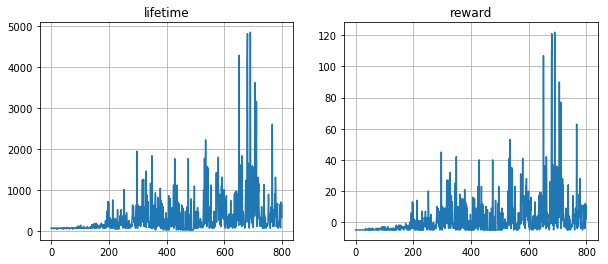

In [28]:
# mainクラス
flappy_env = Environment()
flappy_env.run()
flappy_env.play()

In [34]:
torch.save(flappy_env.agent.brain.model.state_dict(), 'weight.pth')